# Analysis Processes for Upper Slope & Axis ADCPs

Primary notebook to create spectral and velocity plots for either the Upper Slope or Axis ADCP velocity data.

## Imports

Necessary modules for analysis.

In [1]:
# import modules
import xarray as xr
import datetime
import cmath
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import numpy.ma as ma
import scipy.signal as sig
import scipy.integrate as integ
import scipy.interpolate as interp
import pandas as pd
import seawater as sea
from scipy.stats import chi2
from scipy.io import loadmat
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

for i in range(2):
    %matplotlib notebook

## Data

Choose Upper Slope or Axis data, in NetCDF format, and visualise data to check for coverage.

In [2]:
# import data

adcp = 'Axis55'     # Slope, Axis75, Axis55
season = 'Annual'  # Annual, Winter, Spring, Summer, Fall

if adcp == 'Slope':
    ds = xr.open_dataset(f'../Data/{adcp}All/{adcp}_all.nc')
    name = 'Slope'
elif adcp == 'Axis75':
    ds = xr.open_dataset(f'../Data/AxisAll/{adcp}/{adcp}_all.nc')
    name = 'Axis'   # for consistent naming between Axis 75 and 55 kHz
elif adcp == 'Axis55':
    ds = xr.open_dataset(f'../Data/AxisAll/{adcp}/{adcp}_all.nc')
    name = 'Axis'   # for consistent naming between Axis 75 and 55 kHz  
    
# ds = xr.open_dataset('../Data/Raw/Axis55_Feb1_Feb7_2017/1.nc')
# adcp = 'Axis75'
# name = 'Axis75'

print(ds)

<xarray.Dataset>
Dimensions:   (depth: 49, time: 101859)
Coordinates:
  * depth     (depth) int64 13 33 53 73 93 113 133 ... 873 893 913 933 953 973
  * time      (time) datetime64[ns] 2017-01-18T19:07:30.000009984 ... 2019-12-24T01:07:30.000009984
Data variables:
    u         (time, depth) float64 ...
    v         (time, depth) float64 ...
    w         (time, depth) float64 ...
    pressure  (time) float32 ...
    temp      (time) float32 ...


<IPython.core.display.Javascript object>


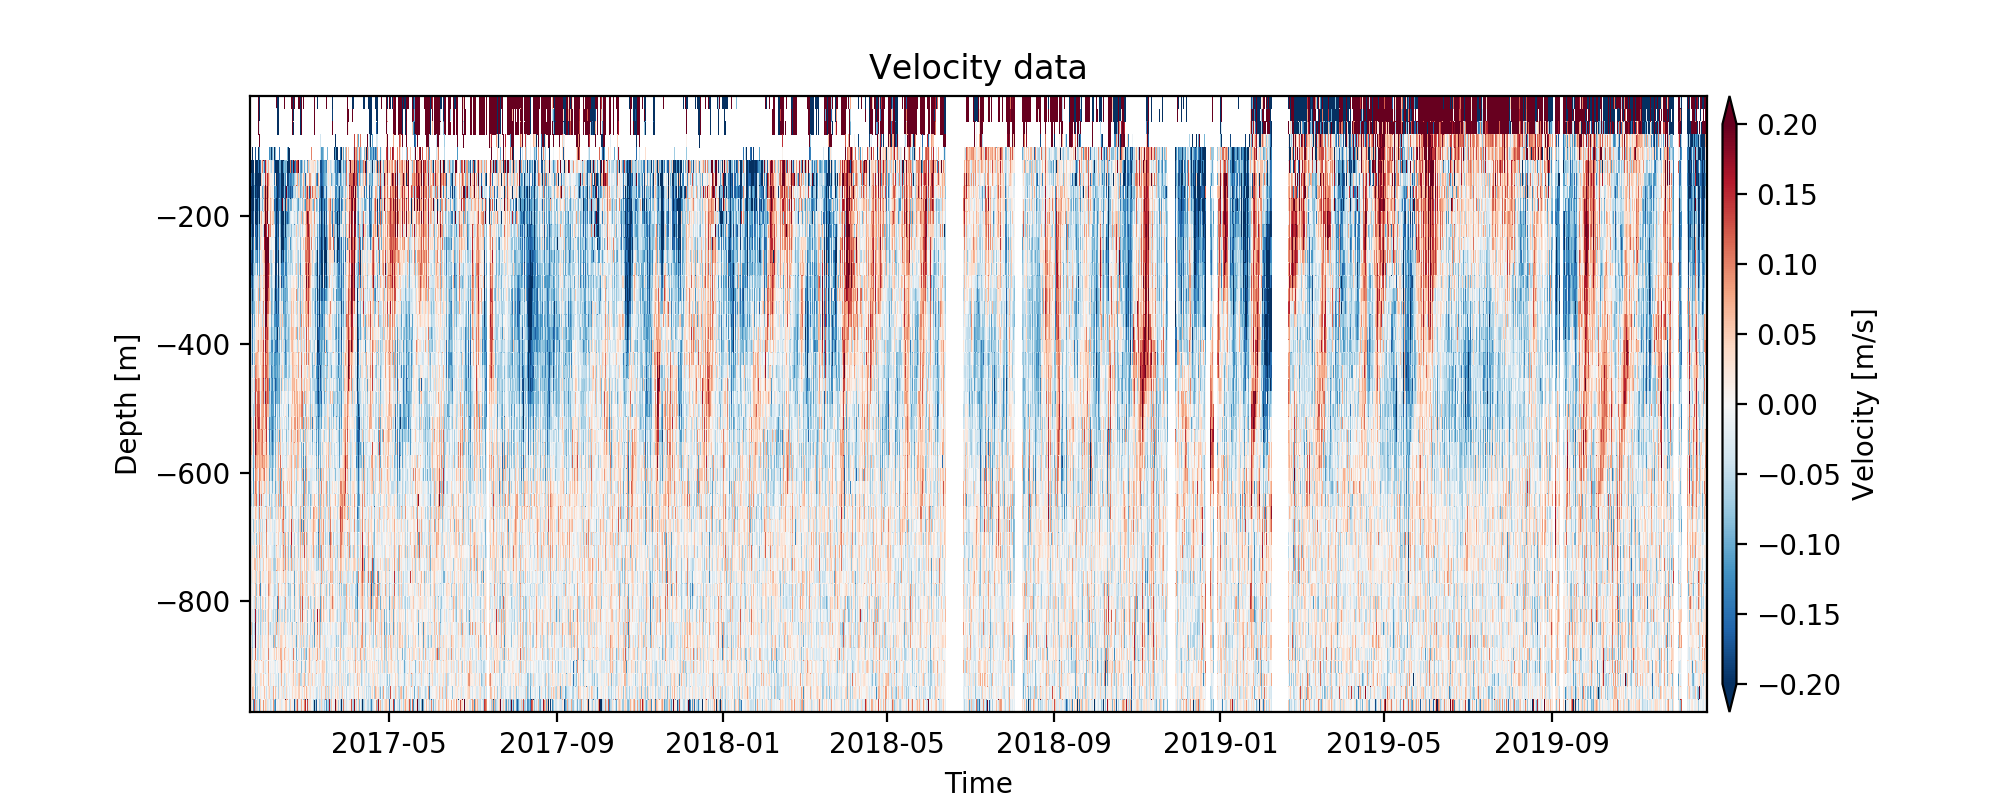

In [4]:
# plot dataset to check data quality

fig,ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(ds.time, -ds.depth, ds.u.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar.set_label('Velocity [m/s]')
ax.set_xlabel('Time')
ax.set_ylabel('Depth [m]')
ax.set_title('Velocity data')
plt.show()

## Depth

Truncate data to a specific depth interval to eliminate unreliable data (from visual inspection of velocity plots), approximately 50-100 m from the upper and lower extremes of the ADCP beams.

In [ ]:
# process to find nearby indices for desired depth values
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx      # returns index of nearest depth value

array = ds.depth    # input array to process 
if adcp=='Slope':
    upval = 100         # upper depth for data, metres (upper slope)
    lowval = 350        # lower depth for data (upper slope)
elif adcp=='Axis75' or adcp=='Axis55':
    upval = 700         # upper depth for data, metres (axis)
    lowval = 900        # lower depth for data (axis)
    
upidx = find_nearest(array, upval)                 # index of upper depth cutoff
lowidx = find_nearest(array,lowval)+1              # index of lower depth cutoff 

print("Index at upper depth cutoff:", upidx)
print("Value at upper depth cutoff:", -ds.depth.values[upidx], "metres" )
print('---')
print("Index at lower depth cutoff:", lowidx)
print("Value at lower depth cutoff:", -ds.depth.values[lowidx], "metres" )

depth = np.array(ds.depth[upidx:lowidx+1])         # remove unwanted depths
dup_stamp = int(-depth[0])                         # depth stamps for use in output filenames
dlow_stamp = int(-depth[-1])

print('---')
print("Length of new depth array: ", len(depth))   # new depth interval
print(f'Upper limit at',dup_stamp,'metres')         # depth for upper PSD
print(f'Lower limit at',dlow_stamp,'metres')        # depth for lower PSD

## Time

Find specific time range and format dates for plotting. If significant *consecutive* NaN values are present, then shorten series for that particular segment.

In [ ]:
# set date range

datestimes = pd.to_datetime(ds.time.values)            # convert to datetime from datetime64
datestimes = pd.Series(datestimes)                     # convert to pandas dataframe

start_date = pd.datetime(2018,1,1)                     # input start date in YYYY,MM,DD
end_date = pd.datetime(2019,1,1)                       # input end date in YYYY,MM,DD
start = datestimes[datestimes >= start_date].index[0]                # desired start date
end = datestimes[datestimes < end_date].index[-1]                    # desired end date
time_test = ds.time.values[start:end]                                # test desired interval
t_stamp = f'{datestimes.dt.year[start]}'                             # set year time stamp for output filenames
print("Desired time range:",np.min(time_test),np.max(time_test))     # print to check desired interval

In [ ]:
# check time series for significant data gaps

depth_test = ds.depth[lowidx-5]                        # mid depth for NaN testing
print('Checked at depth',-depth_test.values,'m')
print('')

u_test = np.array(ds.u[start:end,lowidx-5])            # u data at this depth
counter = 0                                            # counter to keep track of # of consecutive NaN values
nan_list = [0]                                         # empty list to keep track of NaN indices

for i in range(len(time_test)):                        # loop to count consecutive NaN values
    if np.isnan(u_test[i])==True:                      # add to counter if NaN = true
        counter += 1
        if counter==100:                               # length of NaN gap
            dead = i-100                               # datetime series hits significant NaN interval
            nan_list.append(dead)                      # append end of good data index to nan_list
            print('Good data until:',np.max(time_test[dead+1]))
            print('')
        elif counter > 100 and i < (len(time_test)-1):   # if NaNs, but before the end of the interval
            if np.isnan(u_test[i+1])==False:           # if next value is NOT a NaN
                nan_list.append(i+1)                   # append that index to nan_list as start of good data
                print('Good data resets at:',time_test[i])
    elif np.isnan(u_test[i])==False:                   # reset counter if NaN inconsistent
        counter = 0

if (len(nan_list)%2) != 0:
    nan_list.append(len(time_test))

u_test = np.array(ds.u[start:end,upidx:lowidx+1])      # total u for interval and depth, to chop
v_test = np.array(ds.v[start:end,upidx:lowidx+1])      # total v for interval and depth, to chop
u_seg = []                                             # empty list for u segment arrays
v_seg = []                                             # empty list for v segment arrays
t_seg = []                                             # empty list for u segment time intervals

for i in range(len(nan_list)):                         # for the number of NaN indices found
    if i%2 != 0:                                       # for every second index
        u_seg.append(np.array(u_test[nan_list[i-1]:nan_list[i],:]))      # create arrays of good u data
        v_seg.append(np.array(v_test[nan_list[i-1]:nan_list[i],:]))      # create arrays of good v data
        t_seg.append(np.array(time_test[nan_list[i-1]:nan_list[i]]))     # and their time intervals

n_seg = len(u_seg)
print('')
print('Number of segments:',n_seg)
for i in range(n_seg):
    print('Length of segments:',len(t_seg[i]))

# plot specified time intervals to check data quality
fig,ax = plt.subplots(figsize=(10,4))
for i in range(n_seg):
    im = ax.pcolormesh(t_seg[i], -depth, u_seg[i].T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')
ax.set_xlim(start_date,end_date)
cbar.set_label('Velocity [m/s]')
ax.set_xlabel('Time')
ax.set_ylabel('Depth [m]')
ax.set_title('Velocity data')
plt.show()

## Clean

Data rotated based on a visual estimate of along-slope angle, as 30$^{\circ}$. This could be updated to reflect Thomson's work at the A1 site, relatively nearby.

Data are also interpolated to deal with minor instances of NaN values in both depth and time. Consistent NaN intervals are dealt with in the Time section, above.

In [ ]:
# process to rotate, interpolate, and filter raw data (no significant data gaps)

uorig_list,ulp_list,uhp_list,vorig_list,vlp_list,vhp_list = [],[],[],[],[],[]   # empty lists for clean data

for i in range(n_seg):

    # rotate data

    theta_along_slope = np.radians(30)                       # rotation angle in radians, 30 degrees
    u_vec = u_seg[i] + 1j*v_seg[i]                           # vector form of horizontal velocity
    u_vec_new = u_vec*np.exp(-1j*theta_along_slope)          # rotated velocity vector
    u_rot = np.real(u_vec_new)                               # u_new = Re(rotated vector)
    v_rot = np.imag(u_vec_new)                               # v_new = Im(rotated vector)                       

    # filter small NaN instances from data

    t = len(t_seg[i])                        # number of time data points after checking for consistent NaN intervals
    d = len(depth)                           # number of depth data points after removing unwanted depths

    uorig_temp = np.empty([t,d])             # empty array for interpolated & rotated u data
    vorig_temp = np.empty([t,d])             # empty array for interpolated & rotated v data

    for j in range(d):                       # loop to interpolate small gaps at each depth
        utemp = pd.Series(u_rot[:,j])
        uint = utemp.interpolate(method="linear", limit = 100, limit_direction='both')
        uorig_temp[:,j] = uint               # set interpolated data to original array
        vtemp = pd.Series(v_rot[:,j])
        vint = vtemp.interpolate(method="linear", limit = 100, limit_direction='both')
        vorig_temp[:,j] = vint               # set interpolated data to original array

    # low pass Butterworth filter for 40 hour cut-off to remove 30 hour tides

    fs = 4                                   # samples per HOUR for entire time series
    fc = 0.025                               # 40 hour low pass filter cut-off
    Wn = fc / (fs / 2)                       # normalised cut-off frequencies
    b, a = sig.butter(8, Wn,'lowpass')       # digital butterworth filter
    w, h = sig.freqz(b, a)    

    ulp_temp = np.empty([t,d])               # empty array for low-pass filtered u values
    vlp_temp = np.empty([t,d])               # empty array for low-pass filtered v values
    uhp_temp = np.empty([t,d])               # empty array for residual u values
    vhp_temp = np.empty([t,d])               # empty array for residual v values

    for j in range(d):                       # loop for filtered and residual velocities
        ufilt = np.copy(uorig_temp[:,j])     # copy unfiltered array
        ulp_temp[:,j] = sig.filtfilt(b, a, ufilt)  # apply low pass filter
        uhp_temp[:,j] = ufilt - ulp_temp[:,j]      # subtract lp from unfiltered to get residual

        vfilt = np.copy(vorig_temp[:,j])           # repeat for v
        vlp_temp[:,j] = sig.filtfilt(b, a, vfilt)
        vhp_temp[:,j] = vfilt - vlp_temp[:,j]

    uorig_list.append(uorig_temp)                  # append cleaned data to lists
    vorig_list.append(vorig_temp)
    ulp_list.append(ulp_temp)
    vlp_list.append(vlp_temp)
    uhp_list.append(uhp_temp)
    vhp_list.append(vhp_temp) 

if n_seg > 1:
    uorig = uorig_list
    vorig = vorig_list
    ulp = ulp_list
    vlp = vlp_list
    uhp = uhp_list
    vhp = vhp_list
if n_seg == 1:
    uorig = uorig_list[0]
    vorig = vorig_list[0]
    ulp = ulp_list[0]
    vlp = vlp_list[0]
    uhp = uhp_list[0]
    vhp = vhp_list[0]

# Spectra

PSD, spectrograms, and rotary spectra.

## PSD

Removes the mean from upper and lower depth limits. Also obtains depth mean data for an average spectra through depth. Performs Welch FFT with adjustable parameters, using a Parzen window and what seems to be an optimal averaging process, based on visual analysis of spectral output. Calculates 95% confidence intervals using a chi$^2$ method, the GM reference spectra is imported from gm.ipynb, and the noise floor is shown.

In [ ]:
# remove mean from upper and lower depth limits

umup_list,vmup_list,umlow_list,vmlow_list = [],[],[],[]

if n_seg > 1:
    for i in range(n_seg):
        # upper depth limit
        u_up = np.copy(uorig[i][:,0])         # copy rotated / cleaned data
        v_up = np.copy(vorig[i][:,0])
        umup_temp = u_up - np.nanmean(u_up)   # substract the mean
        vmup_temp = v_up - np.nanmean(v_up)

        # lower depth limit
        u_low = np.copy(uorig[i][:,-1])  
        v_low = np.copy(vorig[i][:,-1])
        umlow_temp = u_low - np.nanmean(u_low)
        vmlow_temp = v_low - np.nanmean(v_low)

        umup_list.append(umup_temp)
        vmup_list.append(vmup_temp)
        umlow_list.append(umlow_temp)
        vmlow_list.append(vmlow_temp)
        
    umup = umup_list
    vmup = vmup_list
    umlow = umlow_list
    vmlow = vmlow_list
        
elif n_seg == 1:
    # upper depth limit
    u_up = np.copy(uorig[:,0])         # copy rotated / cleaned data
    v_up = np.copy(vorig[:,0])
    umup_temp = u_up - np.nanmean(u_up)   # substract the mean
    vmup_temp = v_up - np.nanmean(v_up)
    
    # lower depth limit
    u_low = np.copy(uorig[:,-1])  
    v_low = np.copy(vorig[:,-1])
    umlow_temp = u_low - np.nanmean(u_low)
    vmlow_temp = v_low - np.nanmean(v_low)
    
    umup_list.append(umup_temp)
    vmup_list.append(vmup_temp)
    umlow_list.append(umlow_temp)
    vmlow_list.append(vmlow_temp)
    
    umup = umup_list[0]
    vmup = vmup_list[0]
    umlow = umlow_list[0]
    vmlow = vmlow_list[0]

In [ ]:
# Welch FFT

umlow_f_list,umlow_PSD_list,vmlow_f_list,vmlow_PSD_list,umup_f_list,umup_PSD_list,vmup_f_list,vmup_PSD_list=[],[],[],[],[],[],[],[]

time_total = 0
for i in range(n_seg):
    time_total += len(t_seg[i])

# set Welch parameters
fs = 1.11e-3                  # 4 samples per HOUR, 1.11e-3 per SECOND
win = 'hann'                  # optimal window for averaging
if time_total >= 20000:
    nps = 1024               # find optimal average for nperseg, use //40 for annual, //20 for seasonal
elif time_total < 20000:
    nps = 512
overlap = nps // 2            # 50% overlap, default   

t_seg_PSD = t_seg
t_short = []
if n_seg > 1:
    for i in range(n_seg):
        if len(t_seg_PSD[i]) < nps:
            t_short.append(i)
    t_seg_PSD = np.delete(t_seg_PSD,t_short)
    umup = np.delete(umup,t_short)
    vmup = np.delete(vmup,t_short)
    umlow = np.delete(umlow,t_short)
    vmlow = np.delete(vmlow,t_short)
    n_seg_PSD = n_seg - len(t_short)
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
    print(len(t_short),'segment too short, new total time length:',time_total)
elif n_seg == 1:
    n_seg_PSD = n_seg

if n_seg_PSD > 1:
    for i in range(n_seg_PSD):  
        # lower depth
        umlow_f_temp,umlow_PSD_temp=sig.welch(umlow[i],fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)
        vmlow_f_temp,vmlow_PSD_temp=sig.welch(vmlow[i],fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)

        # upper depth
        umup_f_temp,umup_PSD_temp=sig.welch(umup[i],fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)
        vmup_f_temp,vmup_PSD_temp=sig.welch(vmup[i],fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)

        umlow_f_list.append(umlow_f_temp)
        umlow_PSD_list.append(umlow_PSD_temp)
        vmlow_f_list.append(vmlow_f_temp)
        vmlow_PSD_list.append(vmlow_PSD_temp)
        umup_f_list.append(umup_f_temp)
        umup_PSD_list.append(umup_PSD_temp)
        vmup_f_list.append(vmup_f_temp)
        vmup_PSD_list.append(vmup_PSD_temp)
        
    umlow_f = umlow_f_list[0]
    umlow_PSD_seg = umlow_PSD_list
    vmlow_f = vmlow_f_list[0]
    vmlow_PSD_seg = vmlow_PSD_list
    umup_f = umup_f_list[0]
    umup_PSD_seg = umup_PSD_list
    vmup_f = vmup_f_list[0]
    vmup_PSD_seg = vmup_PSD_list

elif n_seg_PSD == 1:
    # lower depth
    umlow_f_temp,umlow_PSD_temp=sig.welch(umlow,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)
    vmlow_f_temp,vmlow_PSD_temp=sig.welch(vmlow,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)

    # upper depth
    umup_f_temp,umup_PSD_temp=sig.welch(umup,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)
    vmup_f_temp,vmup_PSD_temp=sig.welch(vmup,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=True)

    umlow_f_list.append(umlow_f_temp)
    umlow_PSD_list.append(umlow_PSD_temp)
    vmlow_f_list.append(vmlow_f_temp)
    vmlow_PSD_list.append(vmlow_PSD_temp)
    umup_f_list.append(umup_f_temp)
    umup_PSD_list.append(umup_PSD_temp)
    vmup_f_list.append(vmup_f_temp)
    vmup_PSD_list.append(vmup_PSD_temp)
    
    umlow_f = umlow_f_list[0]
    umlow_PSD_seg = umlow_PSD_list[0]
    vmlow_f = vmlow_f_list[0]
    vmlow_PSD_seg = vmlow_PSD_list[0]
    umup_f = umup_f_list[0]
    umup_PSD_seg = umup_PSD_list[0]
    vmup_f = vmup_f_list[0]
    vmup_PSD_seg = vmup_PSD_list[0]

In [ ]:
# combine Welch segments, average with weighting

time_weights = []
if n_seg_PSD > 1:
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
    for i in range(n_seg_PSD):
        t_len = len(t_seg_PSD[i])
        weight_temp = t_len/time_total
        time_weights.append(weight_temp)
elif n_seg_PSD == 1:
    weight_temp = 1
    time_weights = [1]

umlow_PSD_avg_list,vmlow_PSD_avg_list,umup_PSD_avg_list,vmup_PSD_avg_list = [],[],[],[]
if n_seg_PSD > 1:
    for i in range(n_seg_PSD):
        if i == 0:
            umlow_PSD_avg_list.append(umlow_PSD_seg[i]*time_weights[i])
            vmlow_PSD_avg_list.append(vmlow_PSD_seg[i]*time_weights[i])
            umup_PSD_avg_list.append(umup_PSD_seg[i]*time_weights[i])
            vmup_PSD_avg_list.append(vmup_PSD_seg[i]*time_weights[i])
        elif i > 0:
            umlow_PSD_avg_list += (umlow_PSD_seg[i]*time_weights[i])
            vmlow_PSD_avg_list += (vmlow_PSD_seg[i]*time_weights[i])
            umup_PSD_avg_list += (umup_PSD_seg[i]*time_weights[i])
            vmup_PSD_avg_list += (vmup_PSD_seg[i]*time_weights[i])
    umlow_PSD = umlow_PSD_avg_list[0] 
    vmlow_PSD = vmlow_PSD_avg_list[0]
    umup_PSD = umup_PSD_avg_list[0]
    vmup_PSD = vmup_PSD_avg_list[0]
elif n_seg_PSD == 1:
    umlow_PSD = umlow_PSD_seg 
    vmlow_PSD = vmlow_PSD_seg
    umup_PSD = umup_PSD_seg
    vmup_PSD = vmup_PSD_seg

In [ ]:
# error bars (95% confidence intervals)

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
t_len = time_total                            # length of total interval
NS = t_len / (nps / 2)                        # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

umlow_lower = umlow_PSD * cint[0]             # define upper and lower confidence values
umlow_upper = umlow_PSD * cint[1]
vmlow_lower = vmlow_PSD * cint[0]             # define upper and lower confidence values
vmlow_upper = vmlow_PSD * cint[1]
umup_lower = umup_PSD * cint[0]               # define upper and lower confidence values
umup_upper = umup_PSD * cint[1]
vmup_lower = vmup_PSD * cint[0]               # define upper and lower confidence values
vmup_upper = vmup_PSD * cint[1]

In [ ]:
# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:, 0]
gm_psd = gm[:, 1]

In [ ]:
# plot PSD

fig, ax = plt.subplots(1,1,figsize=(9.5,6))

ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") # constituents
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$")    
ax.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$")
ax.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$")
ax.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$")
ax.set_ylim(1e-2,5e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both')
ax.set_title(f'PSD - {name} - {t_stamp}')
ax.set_ylabel('Power spectral density [$(m/s)^2/Hz$]')
ax.set_xlabel('Frequency [Hz]')

if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='gray',ls=':',lw=0.8,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='gray',ls=':',lw=0.8,label='Noise floor')
    
ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='gray',lw=0.8,ls='--', label='GM79 - 1/2 amp.') # 1/2 GM for components
ax.loglog(umup_f, umup_PSD, label=f'{dup_stamp} m - Cross-slope',color='blue',lw=1)
ax.loglog(vmup_f, vmup_PSD, label=f'{dup_stamp} m - Along-slope',color='blue',ls='--',lw=1)
ax.loglog(umlow_f, umlow_PSD, label=f'{dlow_stamp} m - Cross-slope',color='red',lw=1)
ax.loglog(vmlow_f, vmlow_PSD, label=f'{dlow_stamp} m - Along-slope',color='red',ls='--',lw=1)

ax.fill_between(umup_f, umup_lower, umup_upper, facecolor='blue', alpha=0.1)
ax.fill_between(vmup_f, vmup_lower, vmup_upper, facecolor='blue', alpha=0.1)
ax.fill_between(umlow_f, umlow_lower, umlow_upper, facecolor='red', alpha=0.1)
ax.fill_between(vmlow_f, vmlow_lower, vmlow_upper, facecolor='red', alpha=0.1, label='95% conf. int.')

fig.tight_layout()
plt.legend(loc='upper right',frameon=False,fontsize=9)
plt.show()

plt.savefig(fname='./plots/psd_plots/psd_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

## Rotary

Creates rotary spectra for the mean-removed and cleaned velocity data, and specific depths. Defines a function to return the CW, CCW, cross, and quadrature spectra for any u and v velocity vectors.

Based on Thomson, R. (1997). Data Analysis Methods in Physical Oceanography. pp.427-432,494-500; Gonella, J. (1972) Deep Sea Res. 833-846, and https://pyoceans.github.io/python-oceans/ocfis.html, and further adapted for averaging (Welch) PSD and CSD processes.

In [ ]:
# rotary spectra function

time_total = 0
if n_seg > 1:
    for i in range(n_seg):
        time_total += len(t_seg[i])
elif n_seg == 1:
    time_total = len(t_seg[0])

fs = 1.11e-3                  # 4 samples per HOUR, 1.11e-3 per SECOND
win = 'hann'                  # optimal window for averaging
if time_total >= 20000:
    nps = 1024                # find optimal average for nperseg, use //40 for annual, //20 for seasonal
elif time_total < 20000:
    nps = 512
overlap = nps // 2            # 50% overlap, default     

if adcp == 'Axis55' and t_stamp == '2018':
    if time_total >= 20000:
        nps = 700             # find optimal average for nperseg, use //40 for annual, //20 for seasonal
    elif time_total < 20000:
        nps = 256
    overlap = nps // 2        # 50% overlap, default  
    
def spec_rot(u, v):
    puf, pu = sig.welch(u,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=False)  # auto-spectrum for u
    pvf, pv = sig.welch(v,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=False)  # auto-spectrum for v
    cuvf, cuv = sig.csd(v,u,fs=fs,window=win,nperseg=nps,noverlap=overlap,return_onesided=False)# cross spectra (u,v --> v,u)
    quv = cuv.imag                                      # quadrature spectrum, imaginary part of cross spectra
    cw = ((pu + pv) - (2*quv)) / 2                      # rotatory components
    ccw = ((pu + pv) + (2*quv)) / 2
    F = puf                                             # frequency range (two-sided)
    
    return cuv, quv, cw, ccw, F

In [ ]:
# get lower rotary spectra
d_idx_low = -1                                             # depth index, use -1 for lower, 0 for upper
d_stamp_low = str(int(depth[d_idx_low]))                   # depth stamp for figures

rot_um_low_list,rot_vm_low_list = [],[]

if n_seg > 1:
    for i in range(n_seg):
        rot_u_low = np.copy(uorig[i][:,d_idx_low])                 
        rot_um_low = rot_u_low - np.nanmean(rot_u_low)             # remove mean for rotary spectra
        rot_v_low = np.copy(vorig[i][:,d_idx_low])                 
        rot_vm_low = rot_v_low - np.nanmean(rot_v_low)  
        rot_um_low_list.append(rot_um_low)
        rot_vm_low_list.append(rot_vm_low)
    rot_um_low = rot_um_low_list
    rot_vm_low = rot_vm_low_list
if n_seg == 1:
    rot_u_low = np.copy(uorig[:,d_idx_low])
    rot_um_low = rot_u_low - np.nanmean(rot_u_low)             # remove mean for rotary spectra
    rot_v_low = np.copy(vorig[:,d_idx_low])                 
    rot_vm_low = rot_v_low - np.nanmean(rot_v_low)

if n_seg > 1:
    time_total = 0
    for i in range(n_seg):
        time_total += len(t_seg[i])
    t_seg_PSD = np.copy(t_seg)
    t_short = []
    for i in range(n_seg):
        if len(t_seg_PSD[i]) < nps:
            t_short.append(i)
    if adcp == 'Axis55' and t_stamp == '2018':
        t_short.append(3)
    t_seg_PSD = np.delete(t_seg_PSD,t_short)
    rot_um_low = np.delete(rot_um_low,t_short)
    rot_vm_low = np.delete(rot_vm_low,t_short)
    n_seg_PSD = n_seg - len(t_short)
elif n_seg == 1:
    t_seg_PSD = t_seg
    n_seg_PSD = n_seg

if n_seg_PSD > 1:
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
    print(len(t_short),'segments too short, new total time length:',time_total)    

    cw_real_low_list,ccw_real_low_list,f_rot_low_list = [],[],[]
    for i in range(n_seg_PSD):
        cuv_low, quv_low, cw_low, ccw_low, f_rot = spec_rot(rot_um_low[i],rot_vm_low[i]) # get rotary components (cw and ccw) and frequency range (f)
        half_idx = int((len(cw_low)/2))                            # discard half spectrum for real data 
        cw_real_low = cw_low[0:half_idx]*2                         # mult. amplitude by 2 to account for discarded data
        ccw_real_low = ccw_low[0:half_idx]*2     
        f_rot_low = f_rot[0:half_idx]                              # real frequency range (up to Nyquist)
        cw_real_low_list.append(cw_real_low)
        ccw_real_low_list.append(ccw_real_low)
        f_rot_low_list.append(f_rot_low)    
    f_rot_low = f_rot_low_list[0]
elif n_seg_PSD == 1:   
    cw_real_low_list,ccw_real_low_list,f_rot_low_list = [],[],[]
    cuv_low, quv_low, cw_low, ccw_low, f_rot = spec_rot(rot_um_low,rot_vm_low) # get rotary components (cw and ccw) and frequency range (f)
    half_idx = int((len(cw_low)/2))                            # discard half spectrum for real data 
    cw_real_low = cw_low[0:half_idx]*2                         # mult. amplitude by 2 to account for discarded data
    ccw_real_low = ccw_low[0:half_idx]*2     
    f_rot_low = f_rot[0:half_idx]                              # real frequency range (up to Nyquist)
    cw_real_low_list.append(cw_real_low)
    ccw_real_low_list.append(ccw_real_low)

In [ ]:
# get upper rotary spectra
d_idx_up = 0                                             # depth index, use -1 for lower, 0 for upper
d_stamp_up = str(int(depth[d_idx_up]))                   # depth stamp for figures

rot_um_up_list,rot_vm_up_list = [],[]

if n_seg > 1:
    for i in range(n_seg):
        rot_u_up = np.copy(uorig[i][:,d_idx_up])                 
        rot_um_up = rot_u_up - np.nanmean(rot_u_up)             # remove mean for rotary spectra
        rot_v_up = np.copy(vorig[i][:,d_idx_up])                 
        rot_vm_up = rot_v_up - np.nanmean(rot_v_up)  
        rot_um_up_list.append(rot_um_up)
        rot_vm_up_list.append(rot_vm_up)
    rot_um_up = rot_um_up_list
    rot_vm_up = rot_vm_up_list
if n_seg == 1:
    rot_u_up = np.copy(uorig[:,d_idx_up])
    rot_um_up = rot_u_up - np.nanmean(rot_u_up)             # remove mean for rotary spectra
    rot_v_up = np.copy(vorig[:,d_idx_up])                 
    rot_vm_up = rot_v_up - np.nanmean(rot_v_up)

if n_seg > 1:
    time_total = 0
    for i in range(n_seg):
        time_total += len(t_seg[i])
    t_seg_PSD = np.copy(t_seg)
    t_short = []
    for i in range(n_seg):
        if len(t_seg_PSD[i]) < nps:
            t_short.append(i)
    if adcp == 'Axis55' and t_stamp == '2018':
        t_short.append(3)
    t_seg_PSD = np.delete(t_seg_PSD,t_short)
    rot_um_up = np.delete(rot_um_up,t_short)
    rot_vm_up = np.delete(rot_vm_up,t_short)
    n_seg_PSD = n_seg - len(t_short)
elif n_seg == 1:
    t_seg_PSD = t_seg
    n_seg_PSD = n_seg

if n_seg_PSD > 1:
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
    print(len(t_short),'segments too short, new total time length:',time_total)    

    cw_real_up_list,ccw_real_up_list,f_rot_up_list = [],[],[]
    for i in range(n_seg_PSD):
        cuv_up, quv_up, cw_up, ccw_up, f_rot = spec_rot(rot_um_up[i],rot_vm_up[i]) # get rotary components (cw and ccw) and frequency range (f)
        half_idx = int((len(cw_up)/2))                            # discard half spectrum for real data 
        cw_real_up = cw_up[0:half_idx]*2                         # mult. amplitude by 2 to account for discarded data
        ccw_real_up = ccw_up[0:half_idx]*2     
        f_rot_up = f_rot[0:half_idx]                              # real frequency range (up to Nyquist)
        cw_real_up_list.append(cw_real_up)
        ccw_real_up_list.append(ccw_real_up)
        f_rot_up_list.append(f_rot_up)    
    f_rot_up = f_rot_up_list[0]
elif n_seg_PSD == 1:   
    cw_real_up_list,ccw_real_up_list,f_rot_up_list = [],[],[]
    cuv_up, quv_up, cw_up, ccw_up, f_rot = spec_rot(rot_um_up,rot_vm_up) # get rotary components (cw and ccw) and frequency range (f)
    half_idx = int((len(cw_up)/2))                            # discard half spectrum for real data 
    cw_real_up = cw_up[0:half_idx]*2                         # mult. amplitude by 2 to account for discarded data
    ccw_real_up = ccw_up[0:half_idx]*2     
    f_rot_up = f_rot[0:half_idx]                              # real frequency range (up to Nyquist)
    cw_real_up_list.append(cw_real_up)
    ccw_real_up_list.append(ccw_real_up)

In [ ]:
# combine Welch segments, average with weighting

time_weights = []
if n_seg_PSD > 1:
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg[i])
    for i in range(n_seg_PSD):
        t_len = len(t_seg_PSD[i])
        weight_temp = t_len/time_total
        time_weights.append(weight_temp)
elif n_seg_PSD == 1:
    weight_temp = 1
    time_weights = [1]

cw_real_low_avg_list,ccw_real_low_avg_list,cw_real_up_avg_list,ccw_real_up_avg_list = [],[],[],[]

if n_seg_PSD > 1:
    for i in range(n_seg_PSD):
        if i == 0:
            cw_real_low_avg_list.append(cw_real_low_list[i]*time_weights[i])
            ccw_real_low_avg_list.append(ccw_real_low_list[i]*time_weights[i])
            cw_real_up_avg_list.append(cw_real_up_list[i]*time_weights[i])
            ccw_real_up_avg_list.append(ccw_real_up_list[i]*time_weights[i])
        elif i > 0:
            cw_real_low_avg_list += (cw_real_low_list[i]*time_weights[i])
            ccw_real_low_avg_list += (ccw_real_low_list[i]*time_weights[i])
            cw_real_up_avg_list += (cw_real_up_list[i]*time_weights[i])
            ccw_real_up_avg_list += (ccw_real_up_list[i]*time_weights[i])
elif n_seg_PSD == 1:
    cw_real_low_avg_list = cw_real_low_list
    ccw_real_low_avg_list = ccw_real_low_list
    cw_real_up_avg_list = cw_real_up_list
    ccw_real_up_avg_list = ccw_real_up_list
            
    cw_real_low = cw_real_low_avg_list[0]
    ccw_real_low = ccw_real_low_avg_list[0]
    cw_real_up = cw_real_up_avg_list[0]
    ccw_real_up = ccw_real_up_avg_list[0]

In [ ]:
# error bars (95% confidence intervals)

probability = 0.95                                    # calculate confidence intervals
alpha = 1 - probability    
if n_seg_PSD > 1:
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
elif n_seg_PSD == 1:
    time_total = len(t_seg[0])
t_len = time_total
NS = t_len / (nps / 2)                                # number of estimates, Welch
vp = (4/3)*NS                                         # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp)         # chi**2 distribution
cint = vp/cp                                          # interval coefficients

cw_real_low_lower = cw_real_low * cint[0]             # define upper and lower confidence values
cw_real_low_upper = cw_real_low * cint[1]
ccw_real_low_lower = ccw_real_low * cint[0]           # define upper and lower confidence values
ccw_real_low_upper = ccw_real_low * cint[1]
cw_real_up_lower = cw_real_up * cint[0]               # define upper and lower confidence values
cw_real_up_upper = cw_real_up * cint[1]
ccw_real_up_lower = ccw_real_up * cint[0]             # define upper and lower confidence values
ccw_real_up_upper = ccw_real_up * cint[1]

In [ ]:
# GM rotary spectra
gm = np.loadtxt('../project/archive/GM/gm.dat')        # get GM data from separate code
gm_freq = gm[:, 0]
gm_cw = gm[:, 2]
gm_ccw = gm[:, 3]

In [ ]:
# plot rotary spectra

fig,ax = plt.subplots(1,1,figsize=(9.5,6))               # plot CCW and CW components
ax.set_title(f'Rotary spectra - {name} - {t_stamp}')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(f'Energy density [$(m/s)^2/Hz$]')
ax.set_ylim(1e-2,5e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 
ax.tick_params(axis='both', direction='in', which='both')

ax.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") 
ax.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$")    
ax.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$")
ax.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$")
ax.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$")
if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='gray',ls=':',lw=0.8,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='gray',ls=':',lw=0.8,label='Noise floor')
ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='gray',lw=0.8, label = 'GM79 - cw') 
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='gray',lw=0.8,ls='--', label = 'GM79 - ccw') 

ax.loglog(f_rot_up, cw_real_up, label=f'-{d_stamp_up} m - cw',color='blue',lw=1)
ax.loglog(f_rot_up, ccw_real_up, label=f'-{d_stamp_up} m - ccw',color='blue',ls='--',lw=1)
ax.loglog(f_rot_low, cw_real_low, label=f'-{d_stamp_low} m - cw',color='red',lw=1)
ax.loglog(f_rot_low, ccw_real_low, label=f'-{d_stamp_low} m - ccw',color='red',ls='--',lw=1)

ax.fill_between(f_rot_up, cw_real_up_lower, cw_real_up_upper, facecolor='blue', alpha=0.1)
ax.fill_between(f_rot_up, ccw_real_up_lower, ccw_real_up_upper, facecolor='blue', alpha=0.1)
ax.fill_between(f_rot_low, cw_real_low_lower, cw_real_low_upper, facecolor='red', alpha=0.1)
ax.fill_between(f_rot_low, ccw_real_low_lower, ccw_real_low_upper, facecolor='red', alpha=0.1, label='95% conf. int.')

fig.tight_layout()
plt.legend(loc='upper right',frameon=False,fontsize=9)
plt.show()

plt.savefig(fname='./plots/rot_plots/rot_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

## Spectrograms

Creates a spectrogram for the rotated, cleaned, and mean-removed velocity data. Spectrograms have been 'whitened', and parameters adjusted (as in PSD) for optimal visual clarity.

In [ ]:
# set spectrogram Welch averaging
time_total = 0
if n_seg > 1:
    for i in range(n_seg):
        time_total += len(t_seg[i])
elif n_seg == 1:
    time_total = len(t_seg)

fs = 1.11e-3                 # 4 samples per HOUR, 1.11e-3 per SECOND
win = 'hann'                 # optimal window for averaging
if time_total >= 20000:
    nps = 1024               # find optimal average for nperseg, use //40 for annual, //20 for seasonal
elif time_total < 20000:
    nps = 512
overlap = nps//1.1                  # 1/2 overlap by default

In [ ]:
# upper depth spectrogram process

spect_up,specfu_up,specfv_up,Sxxu_up,Sxxv_up = [],[],[],[],[]  # empty lists for segs
d_idx_up = 0                                            # depth index, use -1 for lower, 0 for upper
d_stamp_up = str(int(depth[d_idx_up]))                  # depth stamp for figures

spectro_um_up_list, spectro_vm_up_list = [],[]
if n_seg > 1:
    for i in range(n_seg):      
        spectro_u_up = np.copy(uorig[i][:,d_idx_up])                 
        spectro_um_up = spectro_u_up - np.nanmean(spectro_u_up) # remove mean for spectrogram
        spectro_v_up = np.copy(vorig[i][:,d_idx_up])                 
        spectro_vm_up = spectro_v_up - np.nanmean(spectro_v_up) 
        spectro_um_up_list.append(spectro_um_up)
        spectro_vm_up_list.append(spectro_vm_up)
    spectro_um_up = spectro_um_up_list
    spectro_vm_up = spectro_vm_up_list

    t_seg_PSD = t_seg
    t_short = []
    for i in range(n_seg):
        if len(t_seg_PSD[i]) < nps:
            t_short.append(i)
    t_seg_PSD = np.delete(t_seg_PSD,t_short)
    spectro_um_up = np.delete(spectro_um_up,t_short)
    spectro_vm_up = np.delete(spectro_vm_up,t_short)
    n_seg_PSD = n_seg - len(t_short)
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
    print(len(t_short),'segments too short, new total time length:',time_total)
elif n_seg == 1:
    t_seg_PSD = t_seg
    n_seg_PSD = n_seg
    spectro_u_up = np.copy(uorig[:,d_idx_up])                 
    spectro_um_up = spectro_u_up - np.nanmean(spectro_u_up) # remove mean for spectrogram
    spectro_v_up = np.copy(vorig[:,d_idx_up])                 
    spectro_vm_up = spectro_v_up - np.nanmean(spectro_v_up)

if n_seg_PSD > 1:
    for i in range(n_seg_PSD): 
        # get spectrogram    
        spectro_u_up_f, spectro_u_up_t, spectro_u_up_Sxx = sig.spectrogram(spectro_um_up[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
        spectro_v_up_f, spectro_v_up_t, spectro_v_up_Sxx = sig.spectrogram(spectro_vm_up[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    
        # 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
        Sxx_u_up_white = np.copy(spectro_u_up_Sxx)
        for j in range(len(spectro_u_up_t)):
            Sxx_u_up_white[:,j] = Sxx_u_up_white[:,j]*(spectro_u_up_f**2)
        Sxx_v_up_white = np.copy(spectro_v_up_Sxx)
        for j in range(len(spectro_v_up_t)):
            Sxx_v_up_white[:,j] = Sxx_v_up_white[:,j]*(spectro_v_up_f**2)
        
        # convert spectro_t to datetime for x-axis on plots
        spectro_t4_up = spectro_u_up_t*fs
        spectro_time_len_up = len(spectro_t4_up)
        spectro_time_axis_up = np.zeros([spectro_time_len_up],dtype='datetime64[s]')
        for k in range(spectro_time_len_up):
            j = np.int(spectro_t4_up[k])
            spectro_time_axis_up[k] = t_seg_PSD[i][j]
    
        spect_up.append(spectro_time_axis_up)   # append arrays to lists
        specfu_up.append(spectro_u_up_f)
        specfv_up.append(spectro_v_up_f)
        Sxxu_up.append(Sxx_u_up_white)
        Sxxv_up.append(Sxx_v_up_white)
elif n_seg_PSD == 1:
    # get spectrogram    
    spectro_u_up_f, spectro_u_up_t, spectro_u_up_Sxx = sig.spectrogram(spectro_um_up, fs=fs, window=win, \
                                                        nperseg = nps, noverlap = overlap, return_onesided=True)
    spectro_v_up_f, spectro_v_up_t, spectro_v_up_Sxx = sig.spectrogram(spectro_vm_up, fs=fs, window=win, \
                                                        nperseg = nps, noverlap = overlap, return_onesided=True)

    # 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
    Sxx_u_up_white = np.copy(spectro_u_up_Sxx)
    for j in range(len(spectro_u_up_t)):
        Sxx_u_up_white[:,j] = Sxx_u_up_white[:,j]*(spectro_u_up_f**2)
    Sxx_v_up_white = np.copy(spectro_v_up_Sxx)
    for j in range(len(spectro_v_up_t)):
        Sxx_v_up_white[:,j] = Sxx_v_up_white[:,j]*(spectro_v_up_f**2)

    # convert spectro_t to datetime for x-axis on plots
    spectro_t4_up = spectro_u_up_t*fs
    spectro_time_len_up = len(spectro_t4_up)
    spectro_time_axis_up = np.zeros([spectro_time_len_up],dtype='datetime64[s]')
    for k in range(spectro_time_len_up):
        j = np.int(spectro_t4_up[k])
        spectro_time_axis_up[k] = t_seg_PSD[0][j]
    
    spect_up.append(spectro_time_axis_up)   # append arrays to lists
    specfu_up.append(spectro_u_up_f)
    specfv_up.append(spectro_v_up_f)
    Sxxu_up.append(Sxx_u_up_white)
    Sxxv_up.append(Sxx_v_up_white)

In [ ]:
# lower depth spectrogram process

spect_low,specfu_low,specfv_low,Sxxu_low,Sxxv_low = [],[],[],[],[]  # empty lists for segs
d_idx_low = -1                                            # depth index, use -1 for lower, 0 for upper
d_stamp_low = str(int(depth[d_idx_low]))                  # depth stamp for figures

spectro_um_low_list, spectro_vm_low_list = [],[]
if n_seg > 1:
    for i in range(n_seg):      
        spectro_u_low = np.copy(uorig[i][:,d_idx_low])                 
        spectro_um_low = spectro_u_low - np.nanmean(spectro_u_low) # remove mean for spectrogram
        spectro_v_low = np.copy(vorig[i][:,d_idx_low])                 
        spectro_vm_low = spectro_v_low - np.nanmean(spectro_v_low) 
        spectro_um_low_list.append(spectro_um_low)
        spectro_vm_low_list.append(spectro_vm_low)
    spectro_um_low = spectro_um_low_list
    spectro_vm_low = spectro_vm_low_list

    t_seg_PSD = t_seg
    t_short = []
    for i in range(n_seg):
        if len(t_seg_PSD[i]) < nps:
            t_short.append(i)
    t_seg_PSD = np.delete(t_seg_PSD,t_short)
    spectro_um_low = np.delete(spectro_um_low,t_short)
    spectro_vm_low = np.delete(spectro_vm_low,t_short)
    n_seg_PSD = n_seg - len(t_short)
    time_total = 0
    for i in range(n_seg_PSD):
        time_total += len(t_seg_PSD[i])
    print(len(t_short),'segments too short, new total time length:',time_total)
elif n_seg == 1:
    t_seg_PSD = t_seg
    n_seg_PSD = n_seg
    spectro_u_low = np.copy(uorig[:,d_idx_low])                 
    spectro_um_low = spectro_u_low - np.nanmean(spectro_u_low) # remove mean for spectrogram
    spectro_v_low = np.copy(vorig[:,d_idx_low])                 
    spectro_vm_low = spectro_v_low - np.nanmean(spectro_v_low)

if n_seg_PSD > 1:
    for i in range(n_seg_PSD): 
        # get spectrogram    
        spectro_u_low_f, spectro_u_low_t, spectro_u_low_Sxx = sig.spectrogram(spectro_um_low[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
        spectro_v_low_f, spectro_v_low_t, spectro_v_low_Sxx = sig.spectrogram(spectro_vm_low[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    
        # 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
        Sxx_u_low_white = np.copy(spectro_u_low_Sxx)
        for j in range(len(spectro_u_low_t)):
            Sxx_u_low_white[:,j] = Sxx_u_low_white[:,j]*(spectro_u_low_f**2)
        Sxx_v_low_white = np.copy(spectro_v_low_Sxx)
        for j in range(len(spectro_v_low_t)):
            Sxx_v_low_white[:,j] = Sxx_v_low_white[:,j]*(spectro_v_low_f**2)
        
        # convert spectro_t to datetime for x-axis on plots
        spectro_t4_low = spectro_u_low_t*fs
        spectro_time_len_low = len(spectro_t4_low)
        spectro_time_axis_low = np.zeros([spectro_time_len_low],dtype='datetime64[s]')
        for k in range(spectro_time_len_low):
            j = np.int(spectro_t4_low[k])
            spectro_time_axis_low[k] = t_seg_PSD[i][j]
    
        spect_low.append(spectro_time_axis_low)   # append arrays to lists
        specfu_low.append(spectro_u_low_f)
        specfv_low.append(spectro_v_low_f)
        Sxxu_low.append(Sxx_u_low_white)
        Sxxv_low.append(Sxx_v_low_white)
elif n_seg_PSD == 1:
    # get spectrogram    
    spectro_u_low_f, spectro_u_low_t, spectro_u_low_Sxx = sig.spectrogram(spectro_um_low, fs=fs, window=win, \
                                                        nperseg = nps, noverlap = overlap, return_onesided=True)
    spectro_v_low_f, spectro_v_low_t, spectro_v_low_Sxx = sig.spectrogram(spectro_vm_low, fs=fs, window=win, \
                                                        nperseg = nps, noverlap = overlap, return_onesided=True)

    # 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
    Sxx_u_low_white = np.copy(spectro_u_low_Sxx)
    for j in range(len(spectro_u_low_t)):
        Sxx_u_low_white[:,j] = Sxx_u_low_white[:,j]*(spectro_u_low_f**2)
    Sxx_v_low_white = np.copy(spectro_v_low_Sxx)
    for j in range(len(spectro_v_low_t)):
        Sxx_v_low_white[:,j] = Sxx_v_low_white[:,j]*(spectro_v_low_f**2)

    # convert spectro_t to datetime for x-axis on plots
    spectro_t4_low = spectro_u_low_t*fs
    spectro_time_len_low = len(spectro_t4_low)
    spectro_time_axis_low = np.zeros([spectro_time_len_low],dtype='datetime64[s]')
    for k in range(spectro_time_len_low):
        j = np.int(spectro_t4_low[k])
        spectro_time_axis_low[k] = t_seg_PSD[0][j]
    
    spect_low.append(spectro_time_axis_low)   # append arrays to lists
    specfu_low.append(spectro_u_low_f)
    specfv_low.append(spectro_v_low_f)
    Sxxu_low.append(Sxx_u_low_white)
    Sxxv_low.append(Sxx_v_low_white)

In [ ]:
# plot spectrogram

fig, axs = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
(ax0,ax1),(ax2,ax3) = axs
fig.subplots_adjust(hspace=0.07, wspace=0.02)
fig.text(0.5, 0.92, f'Spectrograms - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
fig.text(0.92, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')
fig.text(0.125,0.882,f'-{d_stamp_up} m')
fig.text(0.125,0.483,f'-{d_stamp_low} m')
ax0.set_title('Cross-slope')
ax1.set_title('Along-slope')

vmin = 5e-8
vmax = 1e-6

if n_seg_PSD > 1:
    for i in range(n_seg_PSD):
        im0 = ax0.pcolormesh(spect_up[i], specfu_up[i], Sxxu_up[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
        im1 = ax1.pcolormesh(spect_up[i], specfv_up[i], Sxxv_up[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
        im2 = ax2.pcolormesh(spect_low[i], specfu_low[i], Sxxu_low[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')
        im3 = ax3.pcolormesh(spect_low[i], specfv_low[i], Sxxv_low[i], rasterized=True, \
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
elif n_seg_PSD == 1:
    im0 = ax0.pcolormesh(spect_up[0], specfu_up[0], Sxxu_up[0], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im1 = ax1.pcolormesh(spect_up[0], specfv_up[0], Sxxv_up[0], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')  
    im2 = ax2.pcolormesh(spect_low[0], specfu_low[0], Sxxu_low[0], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot')
    im3 = ax3.pcolormesh(spect_low[0], specfv_low[0], Sxxv_low[0], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='hot') 

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')    

ax0.set_yscale('log')
ax0.set_ylim(1e-5,5.55e-4)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
ax0.xaxis.set_major_locator(plt.MaxNLocator(6))

ax0.axhline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$")
ax0.axhline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$")
ax0.axhline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$")
ax0.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$") 
ax0.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$") 
ax1.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax1.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax1.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax1.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax1.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 
ax2.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax2.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax2.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax2.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax2.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 
ax3.axhline(4.472e-5, color ='pink',ls='--',lw=0.8)
ax3.axhline(3.968e-5, color ='gold',ls='--',lw=0.8)
ax3.axhline(2.236e-5, color ='orange',ls='--',lw=0.8)
ax3.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8) 
ax3.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8) 

plt.subplots_adjust(right=0.88)
fig.legend(loc=(0.92,0.756), framealpha=0.6, facecolor='whitesmoke', fontsize=9, frameon=True)
plt.show()

plt.savefig(fname='./plots/spectro_plots/spectro_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

# Velocities

Creates time and depth velocity plots from rotated and cleaned data.

In [ ]:
# plot velocity data w/ mean currents

fig, axs = plt.subplots(2,2, figsize=(10,8), sharex = True, sharey = True)
(ax1,ax4),(ax2,ax5) = axs
fig.subplots_adjust(hspace = 0.09,wspace = 0.03)
fig.text(0.5, 0.92, f'Velocities - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (cleaned)', va='center')
fig.text(0.123, 0.485, 'low-pass (mean currents)', va='center')
fig.text(0.942, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')
ax1.set_title('Cross-slope')
ax4.set_title('Along-slope')

vmin = -0.15
vmax = 0.15

if n_seg > 1:
    for i in range(n_seg):
        im1 = ax1.pcolormesh(t_seg[i], -depth, uorig[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im2 = ax2.pcolormesh(t_seg[i], -depth, ulp[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im4 = ax4.pcolormesh(t_seg[i], -depth, vorig[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im5 = ax5.pcolormesh(t_seg[i], -depth, vlp[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
elif n_seg == 1:
    im1 = ax1.pcolormesh(t_seg, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im2 = ax2.pcolormesh(t_seg, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im4 = ax4.pcolormesh(t_seg, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im5 = ax5.pcolormesh(t_seg, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)

cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=40, extend='both')
    
date_form = pldates.DateFormatter("%m")
ax5.xaxis.set_major_formatter(date_form)
ax5.set_xlim(start_date,end_date)
ax5.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

plt.savefig(fname='./plots/vel_plots/vel_'+adcp+'_'+t_stamp+'.pdf',format='pdf')

In [ ]:
# plot velocity data w/ residual (for seasonal plots)

fig, axs = plt.subplots(3,2, figsize=(10,8), sharex = True, sharey = True)
(ax1,ax4),(ax2,ax5),(ax3,ax6) = axs
fig.subplots_adjust(hspace = 0.09,wspace = 0.03)
fig.text(0.5, 0.92, f'Velocities - {name} - {t_stamp}', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (cleaned)', va='center')
fig.text(0.123, 0.623, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.359, 'residual (tides and continuum)', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')
ax1.set_title('Cross-slope')
ax4.set_title('Along-slope')

vmin = -0.15
vmax = 0.15

if n_seg > 1:
    for i in range(n_seg):
        im1 = ax1.pcolormesh(t_seg[i], -depth, uorig[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im2 = ax2.pcolormesh(t_seg[i], -depth, ulp[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im3 = ax3.pcolormesh(t_seg[i], -depth, uhp[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im4 = ax4.pcolormesh(t_seg[i], -depth, vorig[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im5 = ax5.pcolormesh(t_seg[i], -depth, vlp[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        im6 = ax6.pcolormesh(t_seg[i], -depth, vhp[i].T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
elif n_seg == 1:
    im1 = ax1.pcolormesh(t_seg, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im2 = ax2.pcolormesh(t_seg, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im3 = ax3.pcolormesh(t_seg, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im4 = ax4.pcolormesh(t_seg, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im5 = ax5.pcolormesh(t_seg, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    im6 = ax6.pcolormesh(t_seg, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)

cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=40, extend='both')
cbar6 = fig.colorbar(im6, ax=ax6, fraction=0.05, pad=0.01, aspect=40, extend='both')
    
date_form = pldates.DateFormatter("%m")
ax6.xaxis.set_major_formatter(date_form)
ax6.set_xlim(start_date,end_date)
ax6.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

plt.savefig(fname='./plots/vel_plots/vel_'+adcp+'_'+season+'_'+t_stamp+'.pdf',format='pdf')

# Vertical data

For processing velocity data on the vertical axis, $w$. Needs to be updated before use.

In [ ]:
# clean data, process for w (run horizontal, first)

# w_new = ds.w[start:end,upidx:lowidx+1]   # w based on time and depth filters
# worig = np.empty([t,d])                  # empty array for rotated w data
# wlp = np.empty([t,d])                    # empty array for low-pass filtered w values
# whp = np.empty([t,d])                    # empty array for residual w values

# for j in range(d):                       # loop to filter NaN instances from velocities at each depth
#     wtemp = pd.Series(w_new[:,j])
#     wint = wtemp.interpolate(method="linear", limit_direction='both',limit=96)
#     worig[:,j] = wint                    # set interpolated data to original array
    
# for j in range(d):                       # loop for filtered and residual velocities
#     wint = worig[:,j]
#     wlp[:,j] = sig.filtfilt(b, a, wint)
#     whp[:,j] = wint - wlp[:,j]

In [ ]:
# PSD for w (run horizontal, first)

# fig, axs = plt.subplots(2,1,figsize=(10,8), sharex=True, sharey=True)
# (ax1,ax2) = axs
# fig.subplots_adjust(hspace=0.03, wspace=0)

# ax1.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
# ax1.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz")    
# ax1.axvline(2.236e-5, color ='orange',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
# ax1.axvline(3.968e-5, color ='gold',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
# ax1.axvline(4.472e-5, color ='pink',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
# ax1.tick_params(axis='both', direction='in', which='both')
# ax1.loglog(wmup_f/3600, wmup_PSD*3600)
# #ax1.set_ylim(1e-3,5e2)
# #ax1.set_ylim(1e-2,1e1)
# #ax1.set_xlim(np.min(wmup_f/3600),np.max(wmup_f/3600))

# ax2.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
# ax2.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
# ax2.axvline(2.236e-5, color ='orange',ls='--',lw=0.8)
# ax2.axvline(3.968e-5, color ='gold',ls='--',lw=0.8)
# ax2.axvline(4.472e-5, color ='pink',ls='--',lw=0.8)
# ax2.tick_params(axis='both', direction='in', which='both')
# ax2.loglog(wmlow_f/3600, wmlow_PSD*3600)

# fig.text(0.805, 0.7, f'Depth {dup_stamp} m', va='center',rotation='270')
# fig.text(0.805, 0.3, f'Depth {dlow_stamp} m', va='center',rotation='270')
# fig.text(0.5,0.90,f'$w$ PSD - {name} - Annual {t_stamp}', ha='center', fontsize=12)
# fig.text(0.04, 0.5, 'Power spectral density [$(m/s)^2/Hz$]', va='center', rotation='vertical')
# fig.text(0.5,0.06,'Frequency [Hz]',ha='center')

# ax1.fill_between(wmup_f/3600, wmup_lower*3600, wmup_upper*3600, facecolor='green', alpha=0.1)
# ax2.fill_between(wmlow_f/3600, wmlow_lower*3600, wmlow_upper*3600, facecolor='green', alpha=0.1, label='95% conf. int.')

# plt.subplots_adjust(right=0.8)
# fig.legend(loc=(0.83,0.695), fontsize=9, frameon=False)
# plt.show()

# #plt.savefig(fname='./plots/psd_plots/psd_'+adcp+'_w_'+t_stamp+'.pdf',format='pdf')

In [ ]:
# spectrograms for w (run horizontal, first)

# spectro_w = worig[:,d_idx]                 
# spectro_w -= np.nanmean(worig[:,d_idx])       # remove mean for spectrogram

# # get spectrogram
# spectro_w_f, spectro_w_t, spectro_w_Sxx = sig.spectrogram(spectro_w, fs_x, window=window_x, \
#                                                     nperseg = 256, noverlap = 128, return_onesided=True)
# # 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2
# Sxx_w_white = np.copy(spectro_w_Sxx)
# for i in range(len(spectro_w_t)):
#     Sxx_w_white[:,i] = Sxx_w_white[:,i]*(spectro_w_f**2)

In [ ]:
# plot w spectrograms

# fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True, sharey=True)
# fig.text(0.5, 0.915, f'$w$ Spectrogram - {name} (-{d_stamp} m) - {t_stamp}', ha='center', fontsize=12)
# fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
# fig.text(0.86, 0.5, '$S_{xx}$ [$(m/s)^2*Hz$]', va='center', rotation='vertical')
# fig.text(0.5, 0.04, f'Months in {t_stamp} [mm]', ha='center')

# im = ax.pcolormesh(spectro_time_axis, spectro_w_f/3600, Sxx_w_white, rasterized=True, \
#                     norm=colors.LogNorm(vmin=1e-6, vmax=5e-3), cmap='hot')  
# cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.01, aspect=40, extend='both')

# ax.set_yscale('log')
# date_form = pldates.DateFormatter("%m")
# ax.xaxis.set_major_formatter(date_form)
# ax.set_xlim(start_date,end_date)
# #ax.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))

# ax.axhline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
# ax.axhline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
# ax.axhline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
# ax.axhline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz") 
# ax.axhline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 

# plt.subplots_adjust(right=0.84)
# fig.legend(loc=(0.82,0.75), framealpha=0.8, facecolor='whitesmoke', fontsize=9, frameon=False)
# plt.show()

# plt.savefig(fname='./plots/spectro_plots/spectro_'+adcp+'_w_'+d_stamp+'_'+t_stamp+'.pdf',format='pdf')

In [ ]:
# plot w velocities

# fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,8),sharex=True,sharey=True)
# fig.subplots_adjust(hspace = 0.08,wspace = 0.05)
# fig.text(0.5, 0.92, f'$w$ velocity profile - {name} - {t_stamp}', ha='center', fontsize=12)
# fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
# fig.text(0.123, 0.887, 'original (cleaned)', va='center')
# fig.text(0.123, 0.623, 'low-pass (mean currents)', va='center')
# fig.text(0.123, 0.360, 'residual', va='center')
# fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
# fig.text(0.5, 0.06, f'Months in {t_stamp} [mm]', ha='center')

# im1 = ax1.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
# im2 = ax2.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
# im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
# cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=40, extend='both')
# cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.01, aspect=40, extend='both')
# cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=40, extend='both')

# if adcp == 'Slope':
#     ax1.set_ylim(-380,-13)
# elif adcp == 'Axis':
#     ax1.set_ylim(-970,-336)
# elif adcp == 'Axis55':
#     ax1.set_ylim(-970,-336)

# date_form = pldates.DateFormatter("%m")
# ax3.xaxis.set_major_formatter(date_form)
# ax3.set_xlim(start_date,end_date)
# #ax3.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
# ax3.xaxis.set_major_locator(plt.MaxNLocator(6))

# plt.show()

# plt.savefig(fname='./plots/vel_plots/vel_w_'+adcp+'_'+t_stamp+'.pdf',format='pdf')